## Neural Network

**CIFAR-10** 中含有 10 类图片，图片尺寸为3x32x32，即含有3个颜色通道，每个图片尺寸为32x32像素。

![CIFAR-10](http://pytorch.org/tutorials/_images/cifar10.png)

首先载入相应的功能包，torchvision包可以方便载入很多视觉数据的数据集

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

datasets 函数导入的图像数据为 PIL 图像格式，取值在[0,1]，我们需要归一化到[-1,1]之间。

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10('../_data/cifar10', train=True, transform=transform, download=True)
testset = datasets.CIFAR10('../_data/cifar10', train=False, transform=transform, download=True)

trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


我们可以简单查看一下载入的图片

     plane       dog       horse       plane


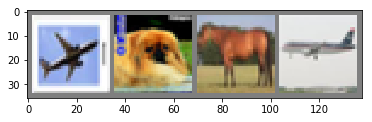

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('  '.join(f'     {classes[labels[j]]}' for j in range(4)))

定义神经网络，首先载入相关类，

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

实例化网络类

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # whether GPU is supportted
net = Net().to(device)

#### 定义损失函数和优化器

这里我们使用交叉熵损失函数和带动量的随机梯度下降算法

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### 网络训练

In [8]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch+1}, {i+1}] loss: {running_loss/2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1, 2000] loss: 2.143
[1, 4000] loss: 1.847
[1, 6000] loss: 1.689
[1, 8000] loss: 1.616
[1, 10000] loss: 1.530
[1, 12000] loss: 1.490
[2, 2000] loss: 1.404
[2, 4000] loss: 1.374
[2, 6000] loss: 1.351
[2, 8000] loss: 1.337
[2, 10000] loss: 1.325
[2, 12000] loss: 1.273
Finished Training


#### 测试网络预测结果

首先可以查看几个示例

GroundTruth:  cat ship ship plane
Predicted:    dog plane ship plane


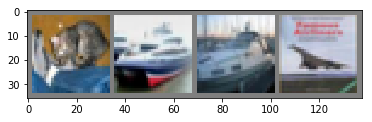

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

查看网络在整个测试集上的性能

In [10]:
correct = 0.
total = 0.
with torch.no_grad(): # will not calculate the culmulated grads and also run faster
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().float()

print(f'Accuracy of the network on the 10000 test images: {100*correct/total:.6f} %')

Accuracy of the network on the 10000 test images: 54.219997 %


以及对于每个分类的预测性能

In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]} : {100*class_correct[i]/class_total[i]} %')

Accuracy of plane : 0.0 %
Accuracy of car : 0.0 %
Accuracy of bird : 0.0 %
Accuracy of cat : 24.3 %
Accuracy of deer : 25.7 %
Accuracy of dog : 25.6 %
Accuracy of frog : 0.0 %
Accuracy of horse : 25.6 %
Accuracy of ship : 0.0 %
Accuracy of truck : 0.0 %


最终保存模型

In [12]:
torch.save(net.state_dict(), 'save/04-2-convolutional neural network cifar-10.pytorch')